In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [2]:
from recalibration import *
from utilities import *
from model import *
from dataloader import *
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
import random
from tueplots import bundles
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-05-25 16:49:05.361116: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [4]:
train_list = [[2361, 7719, 9019, 2335, 7951]]
cal_list = [[5746, 8565, 8156, 8386, 9160]]
test_list = [[4373, 7901, 3456, 3538, 2818]]

In [5]:
dict_bs_lr = {'air': (2048, 0.0001), 'refrigerator': (1024, 0.0001), 'furnace': (
    2048, 0.00001), 'dishwasher': (4096, 0.0001), 'clotheswasher': (2048, 0.0001)}
appliance = 'furnace'

In [6]:
train_houses = train_list[0]
test_houses = test_list[0]
cal_houses = cal_list[0]
train = data_aggregated[data_aggregated["dataid"].isin(train_houses)]
test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]
cal = data_aggregated[data_aggregated["dataid"].isin(cal_houses)]

In [7]:
n = 99
x_train, y_train = dataloader(
    appliance, train, "2018-03-01 00:00:00-06", "2018-03-15 23:59:00-06", n)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)
x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
y_train = jnp.array(y_train)

In [8]:
model = seq2point()
params = model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False,
                     batch_size=dict_bs_lr[f'{appliance}'][0], learning_rate=dict_bs_lr[f'{appliance}'][1], epochs=50)

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress: 100%|██████████| 1850/1850 [00:11<00:00, 154.92epoch/s]


In [9]:
x_test, y_test = dataloader(
    appliance, test, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_test = scaler_x.transform(x_test)
x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
y_test = jnp.array(y_test)

In [10]:
x_cal, y_cal = dataloader(
    appliance, cal, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_cal = scaler_x.transform(x_cal)
x_cal = jnp.array(x_cal).reshape(x_cal.shape[0], n, 1)
y_cal = jnp.array(y_cal)

In [11]:
y_hat_test = model.apply(params, x_test, True, rngs={
                         "dropout": jax.random.PRNGKey(0)})
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]
print(
    f"RMSE : {rmse(y_test, test_mean):.4f}, MAE : {mae(y_test, test_mean):.4f}")

RMSE : 429.3665, MAE : 148.6527


In [12]:
y_hat_train = model.apply(params, x_train, True, rngs={
                          "dropout": jax.random.PRNGKey(0)})
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
print(
    f"RMSE : {rmse(y_train, train_mean):.4f}, MAE : {mae(y_train, train_mean):.4f}")

RMSE : 252.9957, MAE : 92.3016


In [13]:
y_hat_cal = model.apply(params, x_cal, True, rngs={
                        "dropout": jax.random.PRNGKey(0)})
cal_mean = scaler_y.inverse_transform(y_hat_cal[0])
cal_sigma = scaler_y.scale_*y_hat_cal[1]
print(f"RMSE : {rmse(y_cal, cal_mean):.4f}, MAE : {mae(y_cal, cal_mean):.4f}")

RMSE : 800.6897, MAE : 334.6067


## After Calibration

In [14]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

## Conformal Prediction

In [15]:
def find_coverage_calib(y, y_noisy, sigmas, ci, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    q_hats = []
    times = []
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)

    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_noisy + k[i] * sigmas
            initial_lower = y_noisy - k[i] * sigmas
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)

            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times

In [16]:
def find_coverage_train_test(y, y_noisy, sigmas, ci, q_hats, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_noisy + k[i] * sigmas + q_hats[i]
            lower = y_noisy - k[i] * sigmas - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats

In [17]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

Calibration dataset

In [18]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_cal, _, _ = find_coverage_calib(
    y_cal, cal_mean, cal_sigma, ci)

In [19]:
initial_coverages_cal

array([0.        , 0.1020579 , 0.21367823, 0.30650419, 0.37231746,
       0.43914422, 0.52804828, 0.64982593, 0.7808575 , 0.85169435,
       1.        ])

In [20]:
flag = True
final_coverages_cal, q_hats, times = find_coverage_calib(
    y_cal, cal_mean, cal_sigma, ci, flag=flag)

In [21]:
final_coverages_cal

array([0.        , 0.10003085, 0.20003965, 0.30004847, 0.40003526,
       0.50004405, 0.60005289, 0.70003963, 0.80004847, 0.90005726,
       1.        ])

In [22]:
q_hats

[0,
 -0.2872877,
 -1.1758833,
 -0.35064316,
 1.0748348,
 1.188406,
 0.98581314,
 0.6548486,
 0.3375883,
 692.73145,
 0]

In [23]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.3003525763750077 and ece error is 0.027304779670455245
Final ace error is 0.0003965273499488553 and ece error is 3.604794090444139e-05


Training set

In [24]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_train, _ = find_coverage_train_test(
    y_train, train_mean, train_sigma, ci, [])
initial_coverages_train

array([0.        , 0.00520559, 0.01477548, 0.0311284 , 0.04699495,
       0.0608371 , 0.07231307, 0.08574771, 0.10266589, 0.13221684,
       1.        ])

In [25]:
q_hats

[0,
 -0.2872877,
 -1.1758833,
 -0.35064316,
 1.0748348,
 1.188406,
 0.98581314,
 0.6548486,
 0.3375883,
 692.73145,
 0]

In [26]:
flag = True
final_coverages_train, q_hats = find_coverage_train_test(
    y_train, train_mean, train_sigma, ci, q_hats, flag=flag)
print(final_coverages_train)

[0.         0.00515301 0.01390788 0.03052371 0.04849353 0.06308497
 0.07462667 0.08807445 0.10428278 0.98158324 1.        ]


In [27]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 3.948114957194775 and ece error is 0.35891954156316136
Final ace error is 3.2534362322650847 and ece error is 0.29576693020591677


Test set

In [28]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, [])
initial_coverages_test

array([0.        , 0.1363319 , 0.31056026, 0.41875073, 0.50511587,
       0.5514394 , 0.58443284, 0.62573415, 0.70292312, 0.84941858,
       1.        ])

In [29]:
q_hats

[0,
 -0.2872877,
 -1.1758833,
 -0.35064316,
 1.0748348,
 1.188406,
 0.98581314,
 0.6548486,
 0.3375883,
 692.73145,
 0]

In [30]:
flag = True
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, q_hats, flag=flag)
print(final_coverages_test)

[0.         0.13149697 0.29334855 0.41379663 0.51662439 0.56165409
 0.5995335  0.64590818 0.71994758 0.97015607 1.        ]


In [31]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Initial ace error is 0.6596894711256027 and ece error is 0.05997177010232752
Final ace error is 0.6216874539852142 and ece error is 0.05651704127138311


In [32]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

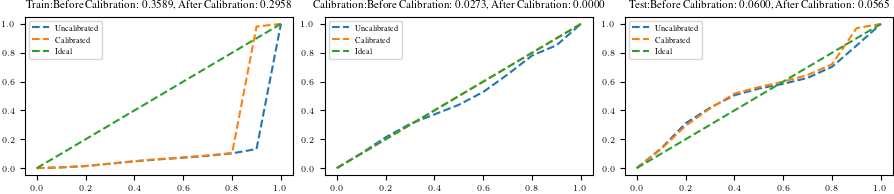

In [33]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')